In [1]:
pip install gym==0.25.2

Cart Pole
===
In this assignment we implement DQN method for the cart pole problem.

Problem Description
---
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. For more information please visit https://www.gymlibrary.dev/environments/classic_control/cart_pole/.

Your Job
---
1. Read https://www.gymlibrary.dev/environments/classic_control/cart_pole/ to understand the environment, states, reward function, etc.
2. Implement the DQN method.
3. Answer the questions in a pdf.
4. Some helpful API documentation can be found here: https://www.gymlibrary.dev/api/core/.

In [33]:
from __future__ import print_function
from __future__ import division
import numpy as np
import gym
from gym import wrappers
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

We use environment 'CartPole-v1'. Run the following cell to test the environment.

In [4]:
## A demo of operating in this environment with a random policy

def run_random_policy(env, gamma, render = False):
    """
    Run 15 episodes by taking random actions.
    args:
    env: gym environment.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    """
    obs = env.reset()
    for i in range(15):
        step_idx = 0
        total_reward = 0
        env.reset()
        while True:
            if render:
                env.render()
            #choose an action randomly.
            #env.step() returns a tuple (state, reward, done) where done is a boolen indicater for episode endings.
            obs, reward, done , _ ,_= env.step(env.action_space.sample())
            total_reward += (gamma ** step_idx * reward)
            step_idx += 1
            if done:
                break

env_name  = 'CartPole-v1'
env = gym.make(env_name).unwrapped
run_random_policy(env, gamma=0.99, render = True)
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [5]:
class DQN(nn.Module):
     #Input: state
     #Output: vector corresponding to state-action values for actions, i.e. Q(s,a).
    def __init__(self):
        super(DQN, self).__init__()

        ########################### Your Code Here ###########################

        'Define a neural network that takes state as an input and outputs Q(s,a) for each actions.'
        'You should use ONLY 1 hidden layer with say 50 hidden nodes and ReLU activation function'
        n_observation = 4
        n_action = 2
        self.layer1 = nn.Linear(n_observation,50)
        self.layer2 = nn.Linear(50,n_action)

        ########################### Your Code Here ###########################

    def forward(self, x):
        ########################### Your Code Here ###########################

        'Define the forward method to get output from your neural network for a given state x as input and return this output'
        x= torch.as_tensor(x).float()
        x= F.relu(self.layer1(x))
        return self.layer2(x)

        ########################### Your Code Here ###########################


def choose_action(model, state, EPSILON = 0.9):
    """
    This is the epsilon-greedy strategy.
    """

    ########################### Your Code Here ###########################
    # print("In Choose Action")

    'Write an epsilon greedy strategy to choose action based upon Q(s,a) calculated through your model'
    'Return the action'
    if np.random.rand() > EPSILON:
      # print("if here")
      return env.action_space.sample()
    else:
      # print("if there")
      with torch.no_grad():
        return np.argmax(model(state).numpy(), axis=0)

    ########################### Your Code Here ###########################

def copy_parameters(local_model, target_model):
    """
    Update model parameters.
    local model (PyTorch model): weights will be copied from.
    target model (PyTorch model): weights will be copied to.
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(local_param.data)

In [42]:
def plot_returns(returns, x, title):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.lineplot(
        data=pd.DataFrame(returns),color=x
    )
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Reward')
    plt.show()


In [45]:
def DQN_update(model, model_ft, gamma, epochs, render = False):
    """
    Use online learning to update DQN.
    args:
    model (DQN): DQN model
    model_ft (DQN): DQN model for fixed target
    """
    reward_history = []
    initial_reward= []
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #feel free to tweak the learning rate

    #run epoches of episodes
    #stop at done or 10k epochs

    for i in range(epochs):
        # print(i)
        state = env.reset()   #reset enviroment. Get initial state.
        total_reward = 0
        total_reward1 = 0

        if i%100 == 0: #update the fixed target network parameters every 100 epochs.
            copy_parameters(model, model_ft)


        ########################### Your Code Here ###########################

        'Train the DQN model'
        'Use SmoothL1Loss() as the loss function'
        'Train it via two methods. '
        '  a) Use the original reward returned by the environment for training'
        '  b) Use the following reward shaping:'
            #x, x_dot, theta, theta_dot = state
            #r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
            #r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
            #reward = r1 + r2
        'We will check if there is a difference in convergence rate with and without this reward shaping.'

        for t in range(5000):
          action = choose_action(model,state)
          next_state, reward, done, _,_ = env.step(action)
          x, x_dot, theta, theta_dot = state
          r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
          r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
          total_reward1 +=reward
          reward = r1 + r2
          total_reward+=reward
          q_ft= reward+gamma*torch.max(model_ft(next_state), dim=0)[0]
          criterion = nn.SmoothL1Loss()(torch.max(model(state), dim=0)[0].unsqueeze(0).unsqueeze(0), q_ft.unsqueeze(0).unsqueeze(0))
        reward_history.append(total_reward)
        initial_reward.append(total_reward1)

    plot_returns(reward_history,"red","With Reward Shaping")
    plot_returns(initial_reward,"blue","Without Reward Shaping")
        ########################### Your Code Here ###########################

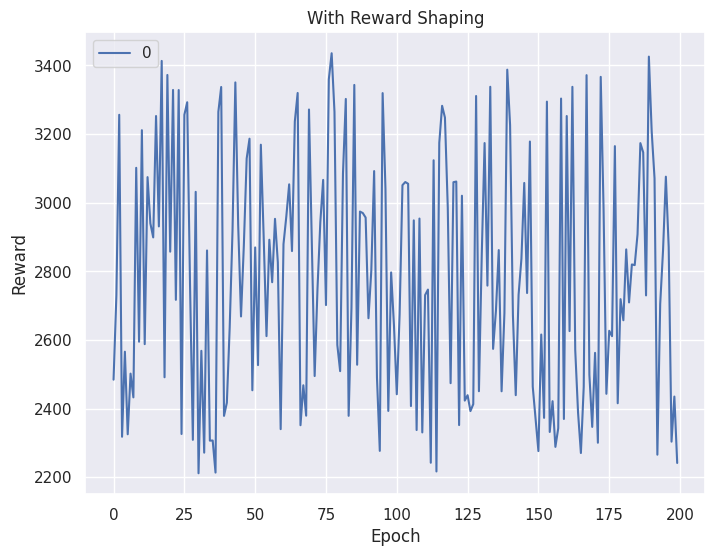

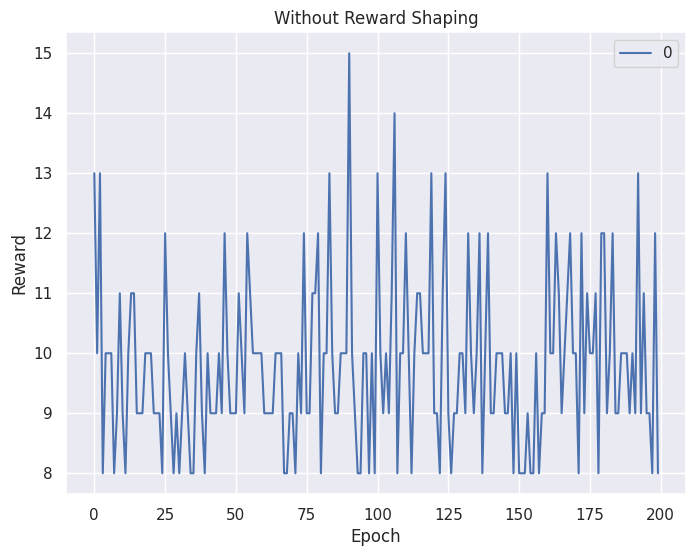

In [46]:
if __name__ == '__main__':
    gamma = 0.99
    np.random.seed(1111)
    env_name  = 'CartPole-v1'
    env = gym.make(env_name).unwrapped
    model = DQN()
    model_ft = DQN()
    DQN_update(model, model_ft, gamma = 0.99, epochs = 200, render = True) #Try different epochs until convergence.
    env.close()

    ## Write any other lines of code if you need it for plotting and other purposes.

Questions (Answer in a separate pdf file)
---

#### 1. Plot the true reward (the reward returned by env.step()) collected against episode during training for both with and without reward shaping case. Note that you still need to plot the true reward in the reward shaping case too.


#### 2. Does the performance improve from episode to episode? Did it overfit?


#### 3. Why do we need two neural networks? Why do we need the fixed target network (model_ft)?


#### 4. How would you modify the above DQN method to double DQN method? Writing a pseudo-code in your answer pdf is fine. You would receive bonus points if you code this method and answer all the other questions for this method as well and provide the code.


#### 5. The above code did not use experience replay. What will be the benefit of using experience replay?
